In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
class TransformerMultiTask(nn.Module):
    def __init__(self, input_dim, num_heads:int, num_layers:int, hidden_dim:int, 
                 entity_id_cls:int, entity_state_cls:int, additional_input_dim:int = 0):
        super(TransformerMultiTask, self).__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        
        transformer_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(transformer_layer, num_layers=num_layers)
        
        # Separate heads for classification tasks
        # Simpler actionable classification head
        self.actionable_fc = nn.Linear(hidden_dim + additional_input_dim, 2)
        
        # Head for complex entity ID classification
        self.entity_id_fc = nn.Sequential(
            nn.Linear(hidden_dim + additional_input_dim, hidden_dim // 2),
            nn.SiLU(),
            nn.Linear(hidden_dim // 2, entity_id_cls)
        )
        
        # Head for entity state classification
        #  - takes the additional inputs and also the outputs of the entity classifications
        self.entity_state_fc = nn.Sequential(
            nn.Linear(hidden_dim + additional_input_dim + entity_id_cls, hidden_dim // 2),
            nn.SiLU(),
            nn.Linear(hidden_dim // 2, entity_state_cls)
        )
        
        # Regression head for action time prediction
        # - takes the additional inputs and also the outputs of the entity classifications
        self.action_time_regression = nn.Linear(hidden_dim + additional_input_dim + entity_id_cls, 1)

    def forward(self, sequence, additional_inputs=None):
        # x shape: (batch_size, seq_length, input_dim)
        embed = self.embedding(sequence)
        x = self.transformer(embed)
        
        # Take the mean across the sequence dimension
        x = x.mean(dim=1)

        # If additional inputs are provided, concatenate them with x
        if additional_inputs is not None:
            x = torch.cat((x, additional_inputs), dim=-1)
        
        # Separate heads for classification and regression
        actionable_output = self.actionable_fc(x)
        entity_id_output = self.entity_id_fc(x)
        # Concatenate x with entity_id_output before passing to entity_state_fc
        x_with_entity_id = torch.cat((x, entity_id_output), dim=-1)
        entity_state_output = self.entity_state_fc(x_with_entity_id)
        time_pred_output = self.action_time_regression(x_with_entity_id)
        
        # return actionable_output, entity_id_output, entity_state_output, time_pred_output
        return actionable_output, entity_id_output, entity_state_output, time_pred_output

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader, IterableDataset
import os
import random
import io
import numpy as np
import pandas as pd
import warnings

# Helper function to convert bytes back to tensor
def bytes_to_tensor(tensor_bytes):
    buffer = io.BytesIO(tensor_bytes)
    loaded_tensor = torch.load(buffer, weights_only=True)
    return loaded_tensor

from torch.utils.data import DataLoader

class MultiPartParquetCASASDataset(IterableDataset):
    def __init__(self, file_list, shuffle_files=True, shuffle_rows=True):
        self.file_list = file_list
        self.shuffle_files = shuffle_files
        self.shuffle_rows = shuffle_rows
        
        if self.shuffle_files:
            random.shuffle(self.file_list)  # Shuffle the order of files

    def _read_parquet_file(self, file_path):
        df = pd.read_parquet(file_path)

        if self.shuffle_rows:
            df = df.sample(frac=1).reset_index(drop=True)  # Shuffle rows within the dataframe

        return df

    def __len__(self):
        total_len = 0
        for file in self.file_list:
            df = self._read_parquet_file(file)
            total_len += len(df)
        return total_len
    
    def __iter__(self):
        with warnings.catch_warnings():
            warnings.simplefilter(action='ignore', category=FutureWarning)
            for file in self.file_list:
                df = self._read_parquet_file(file)
                for _, row in df.iterrows():
                    # shape(batch_size, sequence_length(var))
                    input_tensor = bytes_to_tensor(row['sequence']) 
                    # additional inputs
                    curr_time_hint_tensors = torch.tensor(row[['min', 'hour', 'day', 'week', 'month']])
                    # y labels
                    time_prediction_tensor = torch.tensor(row['secs_from_last'], dtype=torch.float32)
                    actionable_tensor = torch.tensor(not row['sensor_change'], dtype=torch.long)
                    action_entity_id_tensor = torch.tensor(row['changed_entity_id'], dtype=torch.long)
                    action_entity_state_tensor = torch.tensor(float(row['changed_entity_value']), dtype=torch.long)
    
                    yield input_tensor, curr_time_hint_tensors, time_prediction_tensor, actionable_tensor, action_entity_id_tensor, action_entity_state_tensor


def split_file_list(file_list, train_ratio=0.8, test_ratio=0.1, eval_ratio=0.1):
    """
    Split the list of files into train/test/eval based on the given ratios.
    """
    assert train_ratio + test_ratio + eval_ratio == 1.0, "Ratios must sum to 1"
    
    # Shuffle the file list to ensure randomness
    random.shuffle(file_list)
    
    # Split based on the ratio
    total_files = len(file_list)
    train_end = int(train_ratio * total_files)
    test_end = train_end + int(test_ratio * total_files)
    
    train_files = file_list[:train_end]
    test_files = file_list[train_end:test_end]
    eval_files = file_list[test_end:]
    
    return train_files, test_files, eval_files

def _collate_fn(batch):
    # Separate inputs and targets
    input_tensors, curr_time_hint_tensors, time_prediction_tensors, actionable_tensors, action_entity_id_tensors, action_entity_state_tensors = zip(*batch)
    
    # Pad sequences for inputs (batch_first=True makes it [batch_size, seq_len, features])
    input_tensors_padded = pad_sequence(input_tensors, batch_first=True)
    # stack the additional inputs
    curr_time_hint_tensors = torch.stack(curr_time_hint_tensors)
    
    # Convert targets to tensors (they should all have the same length as they're scalar values)
    time_prediction_tensors = torch.stack(time_prediction_tensors)
    actionable_tensors = torch.stack(actionable_tensors)
    action_entity_id_tensors = torch.stack(action_entity_id_tensors)
    action_entity_state_tensors = torch.stack(action_entity_state_tensors)
    
    return input_tensors_padded, curr_time_hint_tensors, time_prediction_tensors, actionable_tensors, action_entity_id_tensors, action_entity_state_tensors


In [4]:
import torch
from tqdm import tqdm
from torch.nn.utils.rnn import pad_sequence

def train_act_model(model, dataloader, num_epochs, 
                actionable_classification_criterion, 
                entity_id_classification_criterion, 
                entity_state_classification_criterion, 
                time_pred_regression_criterion, 
                optimizer, device):
    # Store accuracies and time prediction losses
    actionable_accuracies = []
    entity_id_accuracies = []
    entity_state_accuracies = []
    time_losses = []
    
    model.to(device)
    model.train()
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        correct_entity_state = 0
        total_entity_state = 0
        correct_entity_id = 0
        total_entity_id = 0
        epoch_time_pred_loss = 0
        
        for batch_idx, (input_tensors_padded, curr_time_hint_tensors, time_prediction_tensors, actionable_tensors, action_entity_id_tensors, action_entity_state_tensors) in tqdm(enumerate(dataloader), desc=f"Epoch {epoch+1}/{num_epochs}"):
            # Assuming the dataloader returns a dictionary-like batch with relevant keys
            inputs = input_tensors_padded.to(device)  # shape: (batch_size, max_seq_length, input_dim)
            time_hint_inputs = curr_time_hint_tensors.to(device)
            actionable_labels = actionable_tensors.to(device)  # shape: (batch_size,)
            entity_id_labels = action_entity_id_tensors.to(device)  # shape: (batch_size,)
            entity_state_labels = action_entity_state_tensors.to(device)  # shape: (batch_size,)
            time_pred_labels = time_prediction_tensors.to(device)  # shape: (batch_size,)

            optimizer.zero_grad()

            # Forward pass
            actionable_output, entity_id_output, entity_state_output, time_pred_output = model(inputs, additional_inputs=time_hint_inputs)
            
            # Compute losses
            entity_id_loss = entity_id_classification_criterion(entity_id_output, entity_id_labels)
            entity_state_loss = entity_state_classification_criterion(entity_state_output, entity_state_labels)
            time_pred_loss = time_pred_regression_criterion(time_pred_output.squeeze(), time_pred_labels)

            # Total loss
            total_loss = (entity_id_loss * 8 + entity_state_loss * 1.5 + time_pred_loss * 0.5) / 10
            
            # Backward pass and optimization
            total_loss.backward()
            optimizer.step()
            
            epoch_loss += total_loss.item()
            # accumulate epoch loss
            epoch_time_pred_loss += time_pred_loss.item()
            
            # Calculate entity ID classification accuracy
            _, predicted_entity_id = torch.max(entity_id_output, 1)
            correct_entity_id += (predicted_entity_id == entity_id_labels).sum().item()
            total_entity_id += entity_id_labels.size(0)

            # Calculate entity state classification accuracy
            _, predicted_entity_state = torch.max(entity_state_output, 1)
            correct_entity_state += (predicted_entity_state == entity_state_labels).sum().item()
            total_entity_state += entity_state_labels.size(0)
            
        # Print epoch stats
        avg_loss = epoch_loss / len(dataloader)
        avg_time_pred_loss = epoch_time_pred_loss / len(dataloader)
        time_losses.append(avg_time_pred_loss)
        entity_id_accuracy = 100 * correct_entity_id / total_entity_id
        entity_id_accuracies.append(entity_id_accuracy)
        entity_state_accuracy = 100 * correct_entity_state / total_entity_state
        entity_state_accuracies.append(entity_state_accuracy)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Entity ID Acc: {entity_id_accuracy:.4f}%, Entity state Acc: {entity_state_accuracy:.2f}%, Time Pred Loss: {avg_time_pred_loss:.4f}")

    print("Act Training Complete!")
    return actionable_accuracies, entity_id_accuracies, entity_state_accuracies, time_losses

In [5]:
from os import listdir
from os.path import isfile, join
import re
data_root_path = './data/training_act'
data_pattern = r"^training_data_chunk_slim_\d+\.parquet"
file_list = [join(data_root_path, f) for f in listdir(data_root_path) if isfile(join(data_root_path, f)) and re.match(data_pattern, f)][:100]
# Split the file list
train_files, test_files, eval_files = split_file_list(file_list, train_ratio=0.8, test_ratio=0.1, eval_ratio=0.1)

# Create separate datasets
train_dataset = MultiPartParquetCASASDataset(train_files, shuffle_files=True, shuffle_rows=True)
test_dataset = MultiPartParquetCASASDataset(test_files, shuffle_files=False, shuffle_rows=False)
eval_dataset = MultiPartParquetCASASDataset(eval_files, shuffle_files=False, shuffle_rows=False)

# Wrap them in DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False, collate_fn=_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=_collate_fn)
eval_loader = DataLoader(eval_dataset, batch_size=64, shuffle=False, collate_fn=_collate_fn)


# Actionable Classification Criterion (binary classification)
actionable_classification_criterion = nn.CrossEntropyLoss()

# Entity ID Classification Criterion (multi-class classification)
entity_id_classification_criterion = nn.CrossEntropyLoss()

# Entity State Classification Criterion (multi-class classification)
entity_state_classification_criterion = nn.CrossEntropyLoss()

# Time Prediction Criterion (regression)
time_pred_regression_criterion = nn.MSELoss()



In [12]:
# define the model
model = TransformerMultiTask(input_dim=46, hidden_dim=512, additional_input_dim=5, num_heads=2, num_layers=1, entity_id_cls=45, entity_state_cls=4)
training_epoch = 200
# Using Adam optimizer
import torch.optim as optim
learning_rate = 1e-4  # You can adjust the learning rate as needed
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# find the device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# start the training
_, entity_id_accuracies, entity_state_accuracies, time_losses = train_act_model(model=model, dataloader=train_loader, num_epochs=training_epoch, 
            actionable_classification_criterion=actionable_classification_criterion, 
            entity_id_classification_criterion=entity_id_classification_criterion, 
            entity_state_classification_criterion=entity_state_classification_criterion, 
            time_pred_regression_criterion=time_pred_regression_criterion, 
            optimizer=optimizer, device=device)

Epoch 1/200: 15it [00:07,  2.12it/s]


Epoch [1/200], Loss: 2.7398, Entity ID Acc: 11.7585%, Entity state Acc: 47.35%, Time Pred Loss: 0.3369


Epoch 2/200: 15it [00:06,  2.37it/s]


Epoch [2/200], Loss: 2.2587, Entity ID Acc: 16.1017%, Entity state Acc: 54.87%, Time Pred Loss: 0.2070


Epoch 3/200: 15it [00:06,  2.46it/s]


Epoch [3/200], Loss: 2.0735, Entity ID Acc: 18.5381%, Entity state Acc: 53.81%, Time Pred Loss: 0.1922


Epoch 4/200: 15it [00:06,  2.44it/s]


Epoch [4/200], Loss: 1.9834, Entity ID Acc: 19.9153%, Entity state Acc: 53.50%, Time Pred Loss: 0.1792


Epoch 5/200: 15it [00:06,  2.42it/s]


Epoch [5/200], Loss: 1.9207, Entity ID Acc: 20.4449%, Entity state Acc: 53.92%, Time Pred Loss: 0.1607


Epoch 6/200: 15it [00:06,  2.50it/s]


Epoch [6/200], Loss: 1.8680, Entity ID Acc: 23.9407%, Entity state Acc: 53.81%, Time Pred Loss: 0.1529


Epoch 7/200: 15it [00:06,  2.38it/s]


Epoch [7/200], Loss: 1.8341, Entity ID Acc: 26.0593%, Entity state Acc: 56.78%, Time Pred Loss: 0.1614


Epoch 8/200: 15it [00:06,  2.45it/s]


Epoch [8/200], Loss: 1.8062, Entity ID Acc: 25.5297%, Entity state Acc: 56.99%, Time Pred Loss: 0.1616


Epoch 9/200: 15it [00:06,  2.17it/s]


Epoch [9/200], Loss: 1.7865, Entity ID Acc: 27.9661%, Entity state Acc: 56.99%, Time Pred Loss: 0.1238


Epoch 10/200: 15it [00:06,  2.27it/s]


Epoch [10/200], Loss: 1.7576, Entity ID Acc: 28.9195%, Entity state Acc: 56.46%, Time Pred Loss: 0.1097


Epoch 11/200: 15it [00:06,  2.43it/s]


Epoch [11/200], Loss: 1.7214, Entity ID Acc: 30.8263%, Entity state Acc: 61.76%, Time Pred Loss: 0.1010


Epoch 12/200: 15it [00:06,  2.22it/s]


Epoch [12/200], Loss: 1.7161, Entity ID Acc: 29.7669%, Entity state Acc: 60.06%, Time Pred Loss: 0.1122


Epoch 13/200: 15it [00:06,  2.39it/s]


Epoch [13/200], Loss: 1.7181, Entity ID Acc: 30.1907%, Entity state Acc: 61.55%, Time Pred Loss: 0.1194


Epoch 14/200: 15it [00:06,  2.27it/s]


Epoch [14/200], Loss: 1.6800, Entity ID Acc: 32.0975%, Entity state Acc: 61.44%, Time Pred Loss: 0.0671


Epoch 15/200: 15it [00:06,  2.24it/s]


Epoch [15/200], Loss: 1.6707, Entity ID Acc: 32.6271%, Entity state Acc: 61.44%, Time Pred Loss: 0.0461


Epoch 16/200: 15it [00:06,  2.35it/s]


Epoch [16/200], Loss: 1.6497, Entity ID Acc: 31.9915%, Entity state Acc: 61.02%, Time Pred Loss: 0.0546


Epoch 17/200: 15it [00:06,  2.36it/s]


Epoch [17/200], Loss: 1.6450, Entity ID Acc: 34.2161%, Entity state Acc: 60.70%, Time Pred Loss: 0.0480


Epoch 18/200: 15it [00:06,  2.39it/s]


Epoch [18/200], Loss: 1.6634, Entity ID Acc: 33.2627%, Entity state Acc: 59.43%, Time Pred Loss: 0.0478


Epoch 19/200: 15it [00:06,  2.42it/s]


Epoch [19/200], Loss: 1.6490, Entity ID Acc: 32.7331%, Entity state Acc: 59.75%, Time Pred Loss: 0.0290


Epoch 20/200: 15it [00:06,  2.43it/s]


Epoch [20/200], Loss: 1.6198, Entity ID Acc: 35.1695%, Entity state Acc: 61.65%, Time Pred Loss: 0.0190


Epoch 21/200: 15it [00:06,  2.32it/s]


Epoch [21/200], Loss: 1.5860, Entity ID Acc: 36.1229%, Entity state Acc: 62.92%, Time Pred Loss: 0.0226


Epoch 22/200: 15it [00:06,  2.29it/s]


Epoch [22/200], Loss: 1.5546, Entity ID Acc: 36.8644%, Entity state Acc: 60.28%, Time Pred Loss: 0.0208


Epoch 23/200: 15it [00:05,  2.51it/s]


Epoch [23/200], Loss: 1.5309, Entity ID Acc: 36.8644%, Entity state Acc: 62.71%, Time Pred Loss: 0.0219


Epoch 24/200: 15it [00:06,  2.23it/s]


Epoch [24/200], Loss: 1.4828, Entity ID Acc: 40.2542%, Entity state Acc: 62.82%, Time Pred Loss: 0.0194


Epoch 25/200: 15it [00:06,  2.39it/s]


Epoch [25/200], Loss: 1.4430, Entity ID Acc: 43.6441%, Entity state Acc: 62.08%, Time Pred Loss: 0.0165


Epoch 26/200: 15it [00:06,  2.39it/s]


Epoch [26/200], Loss: 1.4704, Entity ID Acc: 39.1949%, Entity state Acc: 62.61%, Time Pred Loss: 0.0109


Epoch 27/200: 15it [00:06,  2.38it/s]


Epoch [27/200], Loss: 1.4141, Entity ID Acc: 42.4788%, Entity state Acc: 65.47%, Time Pred Loss: 0.0394


Epoch 28/200: 15it [00:07,  2.11it/s]


Epoch [28/200], Loss: 1.3860, Entity ID Acc: 43.1144%, Entity state Acc: 62.92%, Time Pred Loss: 0.0356


Epoch 29/200: 15it [00:06,  2.28it/s]


Epoch [29/200], Loss: 1.3656, Entity ID Acc: 43.4322%, Entity state Acc: 65.57%, Time Pred Loss: 0.0400


Epoch 30/200: 15it [00:06,  2.28it/s]


Epoch [30/200], Loss: 1.3343, Entity ID Acc: 45.4449%, Entity state Acc: 65.47%, Time Pred Loss: 0.0744


Epoch 31/200: 15it [00:06,  2.39it/s]


Epoch [31/200], Loss: 1.2965, Entity ID Acc: 47.7754%, Entity state Acc: 63.56%, Time Pred Loss: 0.1143


Epoch 32/200: 15it [00:07,  2.05it/s]


Epoch [32/200], Loss: 1.2325, Entity ID Acc: 49.7881%, Entity state Acc: 64.41%, Time Pred Loss: 0.0319


Epoch 33/200: 15it [00:06,  2.25it/s]


Epoch [33/200], Loss: 1.2731, Entity ID Acc: 47.5636%, Entity state Acc: 64.51%, Time Pred Loss: 0.0321


Epoch 34/200: 15it [00:06,  2.35it/s]


Epoch [34/200], Loss: 1.2006, Entity ID Acc: 51.9068%, Entity state Acc: 67.37%, Time Pred Loss: 0.0322


Epoch 35/200: 15it [00:06,  2.30it/s]


Epoch [35/200], Loss: 1.1632, Entity ID Acc: 52.5424%, Entity state Acc: 69.60%, Time Pred Loss: 0.0426


Epoch 36/200: 15it [00:06,  2.39it/s]


Epoch [36/200], Loss: 1.0729, Entity ID Acc: 57.3093%, Entity state Acc: 70.76%, Time Pred Loss: 0.0263


Epoch 37/200: 15it [00:06,  2.44it/s]


Epoch [37/200], Loss: 1.0385, Entity ID Acc: 59.2161%, Entity state Acc: 68.96%, Time Pred Loss: 0.0414


Epoch 38/200: 15it [00:05,  2.53it/s]


Epoch [38/200], Loss: 1.0102, Entity ID Acc: 60.2754%, Entity state Acc: 69.28%, Time Pred Loss: 0.0870


Epoch 39/200: 15it [00:05,  2.59it/s]


Epoch [39/200], Loss: 0.9484, Entity ID Acc: 63.6653%, Entity state Acc: 68.86%, Time Pred Loss: 0.0837


Epoch 40/200: 15it [00:06,  2.47it/s]


Epoch [40/200], Loss: 0.9564, Entity ID Acc: 62.7119%, Entity state Acc: 70.66%, Time Pred Loss: 0.0938


Epoch 41/200: 15it [00:06,  2.49it/s]


Epoch [41/200], Loss: 0.9742, Entity ID Acc: 60.2754%, Entity state Acc: 74.26%, Time Pred Loss: 0.1929


Epoch 42/200: 15it [00:06,  2.46it/s]


Epoch [42/200], Loss: 0.9408, Entity ID Acc: 61.6525%, Entity state Acc: 73.52%, Time Pred Loss: 0.0725


Epoch 43/200: 15it [00:05,  2.55it/s]


Epoch [43/200], Loss: 1.0226, Entity ID Acc: 58.1568%, Entity state Acc: 74.68%, Time Pred Loss: 0.0600


Epoch 44/200: 15it [00:06,  2.34it/s]


Epoch [44/200], Loss: 0.8947, Entity ID Acc: 63.6653%, Entity state Acc: 79.03%, Time Pred Loss: 0.0267


Epoch 45/200: 15it [00:06,  2.31it/s]


Epoch [45/200], Loss: 0.9884, Entity ID Acc: 60.2754%, Entity state Acc: 74.05%, Time Pred Loss: 0.0170


Epoch 46/200: 15it [00:07,  2.08it/s]


Epoch [46/200], Loss: 0.9144, Entity ID Acc: 62.1822%, Entity state Acc: 74.36%, Time Pred Loss: 0.0171


Epoch 47/200: 15it [00:06,  2.30it/s]


Epoch [47/200], Loss: 0.9041, Entity ID Acc: 63.7712%, Entity state Acc: 76.06%, Time Pred Loss: 0.0089


Epoch 48/200: 15it [00:06,  2.17it/s]


Epoch [48/200], Loss: 0.8137, Entity ID Acc: 65.3602%, Entity state Acc: 79.45%, Time Pred Loss: 0.0167


Epoch 49/200: 15it [00:06,  2.38it/s]


Epoch [49/200], Loss: 0.7965, Entity ID Acc: 66.5254%, Entity state Acc: 79.77%, Time Pred Loss: 0.0122


Epoch 50/200: 15it [00:06,  2.19it/s]


Epoch [50/200], Loss: 0.7699, Entity ID Acc: 69.5975%, Entity state Acc: 81.67%, Time Pred Loss: 0.0133


Epoch 51/200: 15it [00:06,  2.32it/s]


Epoch [51/200], Loss: 0.7843, Entity ID Acc: 67.9025%, Entity state Acc: 81.04%, Time Pred Loss: 0.0066


Epoch 52/200: 15it [00:05,  2.51it/s]


Epoch [52/200], Loss: 0.7302, Entity ID Acc: 70.6568%, Entity state Acc: 81.46%, Time Pred Loss: 0.0076


Epoch 53/200: 15it [00:05,  2.52it/s]


Epoch [53/200], Loss: 0.7059, Entity ID Acc: 71.6102%, Entity state Acc: 80.19%, Time Pred Loss: 0.0119


Epoch 54/200: 15it [00:05,  2.52it/s]


Epoch [54/200], Loss: 0.7032, Entity ID Acc: 71.5042%, Entity state Acc: 80.19%, Time Pred Loss: 0.0265


Epoch 55/200: 15it [00:06,  2.41it/s]


Epoch [55/200], Loss: 0.7432, Entity ID Acc: 68.5381%, Entity state Acc: 83.26%, Time Pred Loss: 0.0288


Epoch 56/200: 15it [00:05,  2.52it/s]


Epoch [56/200], Loss: 0.6625, Entity ID Acc: 72.7754%, Entity state Acc: 86.23%, Time Pred Loss: 0.0284


Epoch 57/200: 15it [00:05,  2.59it/s]


Epoch [57/200], Loss: 0.6984, Entity ID Acc: 72.7754%, Entity state Acc: 84.96%, Time Pred Loss: 0.0118


Epoch 58/200: 15it [00:06,  2.32it/s]


Epoch [58/200], Loss: 0.6954, Entity ID Acc: 70.9746%, Entity state Acc: 86.23%, Time Pred Loss: 0.0134


Epoch 59/200: 15it [00:05,  2.52it/s]


Epoch [59/200], Loss: 0.6453, Entity ID Acc: 74.3644%, Entity state Acc: 85.70%, Time Pred Loss: 0.0185


Epoch 60/200: 15it [00:06,  2.43it/s]


Epoch [60/200], Loss: 0.6502, Entity ID Acc: 72.0339%, Entity state Acc: 86.02%, Time Pred Loss: 0.0119


Epoch 61/200: 15it [00:05,  2.51it/s]


Epoch [61/200], Loss: 0.6882, Entity ID Acc: 71.9280%, Entity state Acc: 83.26%, Time Pred Loss: 0.0081


Epoch 62/200: 15it [00:05,  2.52it/s]


Epoch [62/200], Loss: 0.6957, Entity ID Acc: 70.8686%, Entity state Acc: 85.49%, Time Pred Loss: 0.0038


Epoch 63/200: 15it [00:06,  2.50it/s]


Epoch [63/200], Loss: 0.6110, Entity ID Acc: 74.3644%, Entity state Acc: 88.24%, Time Pred Loss: 0.0027


Epoch 64/200: 15it [00:05,  2.57it/s]


Epoch [64/200], Loss: 0.5762, Entity ID Acc: 75.7415%, Entity state Acc: 89.09%, Time Pred Loss: 0.0040


Epoch 65/200: 15it [00:06,  2.37it/s]


Epoch [65/200], Loss: 0.6317, Entity ID Acc: 72.1398%, Entity state Acc: 87.08%, Time Pred Loss: 0.0053


Epoch 66/200: 15it [00:06,  2.39it/s]


Epoch [66/200], Loss: 0.5782, Entity ID Acc: 75.7415%, Entity state Acc: 86.55%, Time Pred Loss: 0.0033


Epoch 67/200: 15it [00:06,  2.32it/s]


Epoch [67/200], Loss: 0.6009, Entity ID Acc: 74.5763%, Entity state Acc: 89.09%, Time Pred Loss: 0.0041


Epoch 68/200: 15it [00:05,  2.56it/s]


Epoch [68/200], Loss: 0.7168, Entity ID Acc: 69.5975%, Entity state Acc: 84.75%, Time Pred Loss: 0.0041


Epoch 69/200: 15it [00:05,  2.59it/s]


Epoch [69/200], Loss: 0.6454, Entity ID Acc: 73.4110%, Entity state Acc: 85.38%, Time Pred Loss: 0.0051


Epoch 70/200: 15it [00:05,  2.54it/s]


Epoch [70/200], Loss: 0.5686, Entity ID Acc: 76.6949%, Entity state Acc: 88.03%, Time Pred Loss: 0.0059


Epoch 71/200: 15it [00:06,  2.49it/s]


Epoch [71/200], Loss: 0.5521, Entity ID Acc: 77.4364%, Entity state Acc: 89.51%, Time Pred Loss: 0.0084


Epoch 72/200: 15it [00:06,  2.41it/s]


Epoch [72/200], Loss: 0.5225, Entity ID Acc: 77.8602%, Entity state Acc: 90.25%, Time Pred Loss: 0.0112


Epoch 73/200: 15it [00:06,  2.45it/s]


Epoch [73/200], Loss: 0.5364, Entity ID Acc: 78.1780%, Entity state Acc: 89.62%, Time Pred Loss: 0.0082


Epoch 74/200: 15it [00:08,  1.72it/s]


Epoch [74/200], Loss: 0.5081, Entity ID Acc: 79.9788%, Entity state Acc: 91.10%, Time Pred Loss: 0.0048


Epoch 75/200: 15it [00:06,  2.36it/s]


Epoch [75/200], Loss: 0.5288, Entity ID Acc: 77.5424%, Entity state Acc: 88.45%, Time Pred Loss: 0.0117


Epoch 76/200: 15it [00:06,  2.25it/s]


Epoch [76/200], Loss: 0.5621, Entity ID Acc: 76.3771%, Entity state Acc: 89.72%, Time Pred Loss: 0.0134


Epoch 77/200: 15it [00:06,  2.43it/s]


Epoch [77/200], Loss: 0.5579, Entity ID Acc: 76.1653%, Entity state Acc: 87.18%, Time Pred Loss: 0.0125


Epoch 78/200: 15it [00:05,  2.55it/s]


Epoch [78/200], Loss: 0.5492, Entity ID Acc: 77.1186%, Entity state Acc: 88.56%, Time Pred Loss: 0.0057


Epoch 79/200: 15it [00:05,  2.58it/s]


Epoch [79/200], Loss: 0.5007, Entity ID Acc: 78.2839%, Entity state Acc: 90.68%, Time Pred Loss: 0.0043


Epoch 80/200: 15it [00:06,  2.20it/s]


Epoch [80/200], Loss: 0.4898, Entity ID Acc: 78.3898%, Entity state Acc: 90.47%, Time Pred Loss: 0.0022


Epoch 81/200: 15it [00:06,  2.25it/s]


Epoch [81/200], Loss: 0.4871, Entity ID Acc: 78.8136%, Entity state Acc: 92.80%, Time Pred Loss: 0.0025


Epoch 82/200: 15it [00:06,  2.37it/s]


Epoch [82/200], Loss: 0.5296, Entity ID Acc: 76.1653%, Entity state Acc: 92.48%, Time Pred Loss: 0.0040


Epoch 83/200: 15it [00:06,  2.35it/s]


Epoch [83/200], Loss: 0.5389, Entity ID Acc: 76.5890%, Entity state Acc: 89.19%, Time Pred Loss: 0.0052


Epoch 84/200: 15it [00:06,  2.49it/s]


Epoch [84/200], Loss: 0.5317, Entity ID Acc: 76.5890%, Entity state Acc: 90.25%, Time Pred Loss: 0.0032


Epoch 85/200: 15it [00:05,  2.57it/s]


Epoch [85/200], Loss: 0.5376, Entity ID Acc: 76.6949%, Entity state Acc: 91.53%, Time Pred Loss: 0.0028


Epoch 86/200: 15it [00:06,  2.45it/s]


Epoch [86/200], Loss: 0.5259, Entity ID Acc: 76.8008%, Entity state Acc: 92.80%, Time Pred Loss: 0.0044


Epoch 87/200: 15it [00:06,  2.35it/s]


Epoch [87/200], Loss: 0.4968, Entity ID Acc: 78.6017%, Entity state Acc: 88.98%, Time Pred Loss: 0.0045


Epoch 88/200: 15it [00:05,  2.50it/s]


Epoch [88/200], Loss: 0.4662, Entity ID Acc: 81.1441%, Entity state Acc: 89.51%, Time Pred Loss: 0.0056


Epoch 89/200: 15it [00:05,  2.53it/s]


Epoch [89/200], Loss: 0.4516, Entity ID Acc: 81.2500%, Entity state Acc: 93.43%, Time Pred Loss: 0.0029


Epoch 90/200: 15it [00:06,  2.44it/s]


Epoch [90/200], Loss: 0.4508, Entity ID Acc: 81.2500%, Entity state Acc: 92.80%, Time Pred Loss: 0.0028


Epoch 91/200: 15it [00:06,  2.47it/s]


Epoch [91/200], Loss: 0.4215, Entity ID Acc: 81.8856%, Entity state Acc: 93.64%, Time Pred Loss: 0.0021


Epoch 92/200: 15it [00:05,  2.60it/s]


Epoch [92/200], Loss: 0.4391, Entity ID Acc: 81.3559%, Entity state Acc: 92.69%, Time Pred Loss: 0.0015


Epoch 93/200: 15it [00:05,  2.51it/s]


Epoch [93/200], Loss: 0.4555, Entity ID Acc: 80.6144%, Entity state Acc: 94.07%, Time Pred Loss: 0.0018


Epoch 94/200: 15it [00:06,  2.44it/s]


Epoch [94/200], Loss: 0.4228, Entity ID Acc: 81.2500%, Entity state Acc: 94.39%, Time Pred Loss: 0.0016


Epoch 95/200: 15it [00:06,  2.26it/s]


Epoch [95/200], Loss: 0.4363, Entity ID Acc: 81.7797%, Entity state Acc: 93.33%, Time Pred Loss: 0.0026


Epoch 96/200: 15it [00:06,  2.45it/s]


Epoch [96/200], Loss: 0.4218, Entity ID Acc: 81.5678%, Entity state Acc: 94.49%, Time Pred Loss: 0.0022


Epoch 97/200: 15it [00:05,  2.50it/s]


Epoch [97/200], Loss: 0.4295, Entity ID Acc: 81.3559%, Entity state Acc: 92.06%, Time Pred Loss: 0.0030


Epoch 98/200: 15it [00:06,  2.39it/s]


Epoch [98/200], Loss: 0.4130, Entity ID Acc: 83.6864%, Entity state Acc: 90.68%, Time Pred Loss: 0.0023


Epoch 99/200: 15it [00:07,  2.13it/s]


Epoch [99/200], Loss: 0.4050, Entity ID Acc: 84.2161%, Entity state Acc: 90.78%, Time Pred Loss: 0.0022


Epoch 100/200: 15it [00:06,  2.31it/s]


Epoch [100/200], Loss: 0.4025, Entity ID Acc: 83.4746%, Entity state Acc: 90.57%, Time Pred Loss: 0.0019


Epoch 101/200: 15it [00:06,  2.49it/s]


Epoch [101/200], Loss: 0.3980, Entity ID Acc: 82.6271%, Entity state Acc: 93.11%, Time Pred Loss: 0.0024


Epoch 102/200: 15it [00:05,  2.62it/s]


Epoch [102/200], Loss: 0.3872, Entity ID Acc: 83.5805%, Entity state Acc: 94.81%, Time Pred Loss: 0.0025


Epoch 103/200: 15it [00:05,  2.52it/s]


Epoch [103/200], Loss: 0.3676, Entity ID Acc: 83.7924%, Entity state Acc: 94.49%, Time Pred Loss: 0.0026


Epoch 104/200: 15it [00:05,  2.53it/s]


Epoch [104/200], Loss: 0.3902, Entity ID Acc: 83.4746%, Entity state Acc: 95.13%, Time Pred Loss: 0.0017


Epoch 105/200: 15it [00:06,  2.22it/s]


Epoch [105/200], Loss: 0.3971, Entity ID Acc: 82.6271%, Entity state Acc: 93.96%, Time Pred Loss: 0.0033


Epoch 106/200: 15it [00:06,  2.21it/s]


Epoch [106/200], Loss: 0.4185, Entity ID Acc: 80.4025%, Entity state Acc: 94.39%, Time Pred Loss: 0.0018


Epoch 107/200: 15it [00:06,  2.19it/s]


Epoch [107/200], Loss: 0.3905, Entity ID Acc: 81.8856%, Entity state Acc: 95.23%, Time Pred Loss: 0.0017


Epoch 108/200: 15it [00:06,  2.39it/s]


Epoch [108/200], Loss: 0.3681, Entity ID Acc: 82.9449%, Entity state Acc: 95.23%, Time Pred Loss: 0.0020


Epoch 109/200: 15it [00:06,  2.20it/s]


Epoch [109/200], Loss: 0.3502, Entity ID Acc: 84.8517%, Entity state Acc: 95.66%, Time Pred Loss: 0.0024


Epoch 110/200: 15it [00:06,  2.20it/s]


Epoch [110/200], Loss: 0.3523, Entity ID Acc: 84.5339%, Entity state Acc: 96.72%, Time Pred Loss: 0.0026


Epoch 111/200: 15it [00:06,  2.37it/s]


Epoch [111/200], Loss: 0.3660, Entity ID Acc: 83.8983%, Entity state Acc: 95.02%, Time Pred Loss: 0.0021


Epoch 112/200: 15it [00:06,  2.25it/s]


Epoch [112/200], Loss: 0.3777, Entity ID Acc: 82.9449%, Entity state Acc: 95.55%, Time Pred Loss: 0.0013


Epoch 113/200: 15it [00:06,  2.42it/s]


Epoch [113/200], Loss: 0.3311, Entity ID Acc: 85.8051%, Entity state Acc: 96.61%, Time Pred Loss: 0.0018


Epoch 114/200: 15it [00:05,  2.54it/s]


Epoch [114/200], Loss: 0.3533, Entity ID Acc: 84.8517%, Entity state Acc: 95.34%, Time Pred Loss: 0.0017


Epoch 115/200: 15it [00:05,  2.53it/s]


Epoch [115/200], Loss: 0.3656, Entity ID Acc: 84.5339%, Entity state Acc: 94.49%, Time Pred Loss: 0.0017


Epoch 116/200: 15it [00:06,  2.49it/s]


Epoch [116/200], Loss: 0.3769, Entity ID Acc: 83.3686%, Entity state Acc: 94.39%, Time Pred Loss: 0.0016


Epoch 117/200: 15it [00:06,  2.32it/s]


Epoch [117/200], Loss: 0.3426, Entity ID Acc: 84.5339%, Entity state Acc: 94.39%, Time Pred Loss: 0.0019


Epoch 118/200: 15it [00:06,  2.25it/s]


Epoch [118/200], Loss: 0.3443, Entity ID Acc: 85.8051%, Entity state Acc: 96.40%, Time Pred Loss: 0.0028


Epoch 119/200: 15it [00:06,  2.19it/s]


Epoch [119/200], Loss: 0.3495, Entity ID Acc: 84.9576%, Entity state Acc: 95.13%, Time Pred Loss: 0.0026


Epoch 120/200: 15it [00:07,  2.10it/s]


Epoch [120/200], Loss: 0.3180, Entity ID Acc: 85.2754%, Entity state Acc: 95.23%, Time Pred Loss: 0.0018


Epoch 121/200: 15it [00:06,  2.24it/s]


Epoch [121/200], Loss: 0.3502, Entity ID Acc: 85.2754%, Entity state Acc: 93.64%, Time Pred Loss: 0.0019


Epoch 122/200: 15it [00:06,  2.22it/s]


Epoch [122/200], Loss: 0.3551, Entity ID Acc: 83.7924%, Entity state Acc: 95.34%, Time Pred Loss: 0.0016


Epoch 123/200: 15it [00:06,  2.23it/s]


Epoch [123/200], Loss: 0.3736, Entity ID Acc: 83.5805%, Entity state Acc: 94.39%, Time Pred Loss: 0.0021


Epoch 124/200: 15it [00:06,  2.43it/s]


Epoch [124/200], Loss: 0.3383, Entity ID Acc: 84.3220%, Entity state Acc: 93.22%, Time Pred Loss: 0.0024


Epoch 125/200: 15it [00:06,  2.31it/s]


Epoch [125/200], Loss: 0.2914, Entity ID Acc: 88.2415%, Entity state Acc: 95.23%, Time Pred Loss: 0.0017


Epoch 126/200: 15it [00:06,  2.16it/s]


Epoch [126/200], Loss: 0.3206, Entity ID Acc: 86.3347%, Entity state Acc: 93.64%, Time Pred Loss: 0.0019


Epoch 127/200: 15it [00:06,  2.44it/s]


Epoch [127/200], Loss: 0.3124, Entity ID Acc: 86.5466%, Entity state Acc: 94.28%, Time Pred Loss: 0.0024


Epoch 128/200: 15it [00:05,  2.50it/s]


Epoch [128/200], Loss: 0.3115, Entity ID Acc: 86.5466%, Entity state Acc: 94.28%, Time Pred Loss: 0.0022


Epoch 129/200: 15it [00:06,  2.50it/s]


Epoch [129/200], Loss: 0.3131, Entity ID Acc: 86.2288%, Entity state Acc: 96.08%, Time Pred Loss: 0.0020


Epoch 130/200: 15it [00:06,  2.44it/s]


Epoch [130/200], Loss: 0.3018, Entity ID Acc: 87.8178%, Entity state Acc: 95.66%, Time Pred Loss: 0.0017


Epoch 131/200: 15it [00:06,  2.40it/s]


Epoch [131/200], Loss: 0.2940, Entity ID Acc: 87.8178%, Entity state Acc: 95.87%, Time Pred Loss: 0.0015


Epoch 132/200: 15it [00:06,  2.41it/s]


Epoch [132/200], Loss: 0.3020, Entity ID Acc: 86.8644%, Entity state Acc: 94.28%, Time Pred Loss: 0.0023


Epoch 133/200: 15it [00:05,  2.60it/s]


Epoch [133/200], Loss: 0.2921, Entity ID Acc: 86.4407%, Entity state Acc: 95.23%, Time Pred Loss: 0.0022


Epoch 134/200: 15it [00:05,  2.62it/s]


Epoch [134/200], Loss: 0.2838, Entity ID Acc: 88.5593%, Entity state Acc: 94.81%, Time Pred Loss: 0.0024


Epoch 135/200: 15it [00:06,  2.16it/s]


Epoch [135/200], Loss: 0.2698, Entity ID Acc: 88.3475%, Entity state Acc: 95.76%, Time Pred Loss: 0.0021


Epoch 136/200: 15it [00:07,  1.94it/s]


Epoch [136/200], Loss: 0.2558, Entity ID Acc: 89.7246%, Entity state Acc: 97.14%, Time Pred Loss: 0.0024


Epoch 137/200: 15it [00:06,  2.39it/s]


Epoch [137/200], Loss: 0.2749, Entity ID Acc: 87.7119%, Entity state Acc: 95.44%, Time Pred Loss: 0.0024


Epoch 138/200: 15it [00:06,  2.23it/s]


Epoch [138/200], Loss: 0.2517, Entity ID Acc: 90.4661%, Entity state Acc: 96.82%, Time Pred Loss: 0.0019


Epoch 139/200: 15it [00:06,  2.35it/s]


Epoch [139/200], Loss: 0.2786, Entity ID Acc: 87.7119%, Entity state Acc: 96.08%, Time Pred Loss: 0.0018


Epoch 140/200: 15it [00:06,  2.34it/s]


Epoch [140/200], Loss: 0.2870, Entity ID Acc: 86.7585%, Entity state Acc: 93.75%, Time Pred Loss: 0.0021


Epoch 141/200: 15it [00:07,  2.09it/s]


Epoch [141/200], Loss: 0.2773, Entity ID Acc: 88.4534%, Entity state Acc: 94.81%, Time Pred Loss: 0.0026


Epoch 142/200: 15it [00:05,  2.51it/s]


Epoch [142/200], Loss: 0.3114, Entity ID Acc: 86.0169%, Entity state Acc: 94.17%, Time Pred Loss: 0.0014


Epoch 143/200: 15it [00:05,  2.56it/s]


Epoch [143/200], Loss: 0.3517, Entity ID Acc: 83.6864%, Entity state Acc: 94.49%, Time Pred Loss: 0.0020


Epoch 144/200: 15it [00:05,  2.64it/s]


Epoch [144/200], Loss: 0.3156, Entity ID Acc: 85.8051%, Entity state Acc: 94.92%, Time Pred Loss: 0.0014


Epoch 145/200: 15it [00:05,  2.61it/s]


Epoch [145/200], Loss: 0.2812, Entity ID Acc: 88.6653%, Entity state Acc: 96.72%, Time Pred Loss: 0.0012


Epoch 146/200: 15it [00:05,  2.53it/s]


Epoch [146/200], Loss: 0.2588, Entity ID Acc: 89.0890%, Entity state Acc: 96.93%, Time Pred Loss: 0.0018


Epoch 147/200: 15it [00:05,  2.55it/s]


Epoch [147/200], Loss: 0.2603, Entity ID Acc: 88.8771%, Entity state Acc: 97.35%, Time Pred Loss: 0.0021


Epoch 148/200: 15it [00:05,  2.51it/s]


Epoch [148/200], Loss: 0.2425, Entity ID Acc: 89.9364%, Entity state Acc: 97.88%, Time Pred Loss: 0.0014


Epoch 149/200: 15it [00:06,  2.21it/s]


Epoch [149/200], Loss: 0.2516, Entity ID Acc: 89.5127%, Entity state Acc: 96.82%, Time Pred Loss: 0.0015


Epoch 150/200: 15it [00:06,  2.27it/s]


Epoch [150/200], Loss: 0.2384, Entity ID Acc: 89.7246%, Entity state Acc: 97.25%, Time Pred Loss: 0.0017


Epoch 151/200: 15it [00:06,  2.36it/s]


Epoch [151/200], Loss: 0.2324, Entity ID Acc: 91.3136%, Entity state Acc: 97.78%, Time Pred Loss: 0.0020


Epoch 152/200: 15it [00:06,  2.38it/s]


Epoch [152/200], Loss: 0.2794, Entity ID Acc: 87.9237%, Entity state Acc: 97.67%, Time Pred Loss: 0.0024


Epoch 153/200: 15it [00:06,  2.33it/s]


Epoch [153/200], Loss: 0.2969, Entity ID Acc: 85.9110%, Entity state Acc: 97.14%, Time Pred Loss: 0.0029


Epoch 154/200: 15it [00:05,  2.56it/s]


Epoch [154/200], Loss: 0.2742, Entity ID Acc: 88.1356%, Entity state Acc: 96.93%, Time Pred Loss: 0.0025


Epoch 155/200: 15it [00:05,  2.54it/s]


Epoch [155/200], Loss: 0.3572, Entity ID Acc: 85.4873%, Entity state Acc: 95.23%, Time Pred Loss: 0.0023


Epoch 156/200: 15it [00:06,  2.44it/s]


Epoch [156/200], Loss: 0.3860, Entity ID Acc: 81.3559%, Entity state Acc: 95.44%, Time Pred Loss: 0.0025


Epoch 157/200: 15it [00:05,  2.52it/s]


Epoch [157/200], Loss: 0.4271, Entity ID Acc: 80.9322%, Entity state Acc: 96.08%, Time Pred Loss: 0.0025


Epoch 158/200: 15it [00:06,  2.47it/s]


Epoch [158/200], Loss: 0.3626, Entity ID Acc: 83.3686%, Entity state Acc: 93.96%, Time Pred Loss: 0.0029


Epoch 159/200: 15it [00:06,  2.48it/s]


Epoch [159/200], Loss: 0.2854, Entity ID Acc: 87.6059%, Entity state Acc: 95.02%, Time Pred Loss: 0.0029


Epoch 160/200: 15it [00:06,  2.36it/s]


Epoch [160/200], Loss: 0.2633, Entity ID Acc: 88.2415%, Entity state Acc: 97.03%, Time Pred Loss: 0.0024


Epoch 161/200: 15it [00:05,  2.58it/s]


Epoch [161/200], Loss: 0.2553, Entity ID Acc: 89.5127%, Entity state Acc: 96.29%, Time Pred Loss: 0.0017


Epoch 162/200: 15it [00:05,  2.52it/s]


Epoch [162/200], Loss: 0.2620, Entity ID Acc: 88.8771%, Entity state Acc: 95.44%, Time Pred Loss: 0.0017


Epoch 163/200: 15it [00:05,  2.51it/s]


Epoch [163/200], Loss: 0.2425, Entity ID Acc: 89.8305%, Entity state Acc: 96.50%, Time Pred Loss: 0.0017


Epoch 164/200: 15it [00:05,  2.52it/s]


Epoch [164/200], Loss: 0.2183, Entity ID Acc: 90.7839%, Entity state Acc: 97.14%, Time Pred Loss: 0.0016


Epoch 165/200: 15it [00:05,  2.58it/s]


Epoch [165/200], Loss: 0.2310, Entity ID Acc: 90.7839%, Entity state Acc: 97.14%, Time Pred Loss: 0.0013


Epoch 166/200: 15it [00:06,  2.50it/s]


Epoch [166/200], Loss: 0.2277, Entity ID Acc: 90.8898%, Entity state Acc: 97.14%, Time Pred Loss: 0.0013


Epoch 167/200: 15it [00:05,  2.53it/s]


Epoch [167/200], Loss: 0.2462, Entity ID Acc: 89.8305%, Entity state Acc: 96.61%, Time Pred Loss: 0.0013


Epoch 168/200: 15it [00:05,  2.60it/s]


Epoch [168/200], Loss: 0.2580, Entity ID Acc: 89.0890%, Entity state Acc: 96.72%, Time Pred Loss: 0.0019


Epoch 169/200: 15it [00:05,  2.59it/s]


Epoch [169/200], Loss: 0.2745, Entity ID Acc: 88.5593%, Entity state Acc: 94.17%, Time Pred Loss: 0.0031


Epoch 170/200: 15it [00:05,  2.51it/s]


Epoch [170/200], Loss: 0.2725, Entity ID Acc: 87.9237%, Entity state Acc: 94.81%, Time Pred Loss: 0.0029


Epoch 171/200: 15it [00:06,  2.47it/s]


Epoch [171/200], Loss: 0.2631, Entity ID Acc: 88.9831%, Entity state Acc: 97.56%, Time Pred Loss: 0.0017


Epoch 172/200: 15it [00:06,  2.35it/s]


Epoch [172/200], Loss: 0.2474, Entity ID Acc: 89.1949%, Entity state Acc: 97.46%, Time Pred Loss: 0.0018


Epoch 173/200: 15it [00:06,  2.17it/s]


Epoch [173/200], Loss: 0.2559, Entity ID Acc: 88.1356%, Entity state Acc: 97.03%, Time Pred Loss: 0.0023


Epoch 174/200: 15it [00:05,  2.52it/s]


Epoch [174/200], Loss: 0.2530, Entity ID Acc: 89.6186%, Entity state Acc: 97.14%, Time Pred Loss: 0.0026


Epoch 175/200: 15it [00:06,  2.40it/s]


Epoch [175/200], Loss: 0.2514, Entity ID Acc: 89.3008%, Entity state Acc: 96.08%, Time Pred Loss: 0.0021


Epoch 176/200: 15it [00:06,  2.44it/s]


Epoch [176/200], Loss: 0.2498, Entity ID Acc: 89.7246%, Entity state Acc: 95.66%, Time Pred Loss: 0.0017


Epoch 177/200: 15it [00:05,  2.52it/s]


Epoch [177/200], Loss: 0.2221, Entity ID Acc: 90.4661%, Entity state Acc: 95.97%, Time Pred Loss: 0.0013


Epoch 178/200: 15it [00:05,  2.57it/s]


Epoch [178/200], Loss: 0.2128, Entity ID Acc: 91.9492%, Entity state Acc: 97.03%, Time Pred Loss: 0.0014


Epoch 179/200: 15it [00:06,  2.28it/s]


Epoch [179/200], Loss: 0.2172, Entity ID Acc: 91.2076%, Entity state Acc: 97.14%, Time Pred Loss: 0.0015


Epoch 180/200: 15it [00:06,  2.31it/s]


Epoch [180/200], Loss: 0.2401, Entity ID Acc: 88.7712%, Entity state Acc: 95.97%, Time Pred Loss: 0.0015


Epoch 181/200: 15it [00:06,  2.39it/s]


Epoch [181/200], Loss: 0.2566, Entity ID Acc: 89.3008%, Entity state Acc: 95.76%, Time Pred Loss: 0.0015


Epoch 182/200: 15it [00:06,  2.20it/s]


Epoch [182/200], Loss: 0.2339, Entity ID Acc: 90.4661%, Entity state Acc: 96.93%, Time Pred Loss: 0.0015


Epoch 183/200: 15it [00:06,  2.42it/s]


Epoch [183/200], Loss: 0.2378, Entity ID Acc: 89.7246%, Entity state Acc: 96.19%, Time Pred Loss: 0.0011


Epoch 184/200: 15it [00:06,  2.45it/s]


Epoch [184/200], Loss: 0.2032, Entity ID Acc: 91.1017%, Entity state Acc: 97.67%, Time Pred Loss: 0.0013


Epoch 185/200: 15it [00:06,  2.47it/s]


Epoch [185/200], Loss: 0.2028, Entity ID Acc: 90.6780%, Entity state Acc: 97.46%, Time Pred Loss: 0.0011


Epoch 186/200: 15it [00:05,  2.58it/s]


Epoch [186/200], Loss: 0.1931, Entity ID Acc: 91.9492%, Entity state Acc: 98.31%, Time Pred Loss: 0.0014


Epoch 187/200: 15it [00:06,  2.26it/s]


Epoch [187/200], Loss: 0.1907, Entity ID Acc: 92.1610%, Entity state Acc: 97.46%, Time Pred Loss: 0.0011


Epoch 188/200: 15it [00:06,  2.35it/s]


Epoch [188/200], Loss: 0.1740, Entity ID Acc: 92.9025%, Entity state Acc: 98.52%, Time Pred Loss: 0.0011


Epoch 189/200: 15it [00:06,  2.41it/s]


Epoch [189/200], Loss: 0.2020, Entity ID Acc: 91.2076%, Entity state Acc: 98.41%, Time Pred Loss: 0.0012


Epoch 190/200: 15it [00:05,  2.64it/s]


Epoch [190/200], Loss: 0.2365, Entity ID Acc: 89.7246%, Entity state Acc: 96.93%, Time Pred Loss: 0.0013


Epoch 191/200: 15it [00:05,  2.58it/s]


Epoch [191/200], Loss: 0.2159, Entity ID Acc: 91.2076%, Entity state Acc: 96.93%, Time Pred Loss: 0.0015


Epoch 192/200: 15it [00:05,  2.59it/s]


Epoch [192/200], Loss: 0.2153, Entity ID Acc: 90.8898%, Entity state Acc: 95.55%, Time Pred Loss: 0.0012


Epoch 193/200: 15it [00:05,  2.56it/s]


Epoch [193/200], Loss: 0.2022, Entity ID Acc: 91.9492%, Entity state Acc: 97.99%, Time Pred Loss: 0.0012


Epoch 194/200: 15it [00:06,  2.47it/s]


Epoch [194/200], Loss: 0.1911, Entity ID Acc: 91.9492%, Entity state Acc: 98.09%, Time Pred Loss: 0.0012


Epoch 195/200: 15it [00:06,  2.44it/s]


Epoch [195/200], Loss: 0.2119, Entity ID Acc: 90.4661%, Entity state Acc: 97.78%, Time Pred Loss: 0.0014


Epoch 196/200: 15it [00:05,  2.58it/s]


Epoch [196/200], Loss: 0.2054, Entity ID Acc: 91.5254%, Entity state Acc: 98.09%, Time Pred Loss: 0.0013


Epoch 197/200: 15it [00:06,  2.45it/s]


Epoch [197/200], Loss: 0.2124, Entity ID Acc: 91.6314%, Entity state Acc: 97.25%, Time Pred Loss: 0.0014


Epoch 198/200: 15it [00:06,  2.41it/s]


Epoch [198/200], Loss: 0.2040, Entity ID Acc: 91.3136%, Entity state Acc: 97.46%, Time Pred Loss: 0.0012


Epoch 199/200: 15it [00:05,  2.52it/s]


Epoch [199/200], Loss: 0.1987, Entity ID Acc: 91.2076%, Entity state Acc: 97.03%, Time Pred Loss: 0.0012


Epoch 200/200: 15it [00:06,  2.45it/s]

Epoch [200/200], Loss: 0.1850, Entity ID Acc: 91.4195%, Entity state Acc: 97.46%, Time Pred Loss: 0.0014
Act Training Complete!


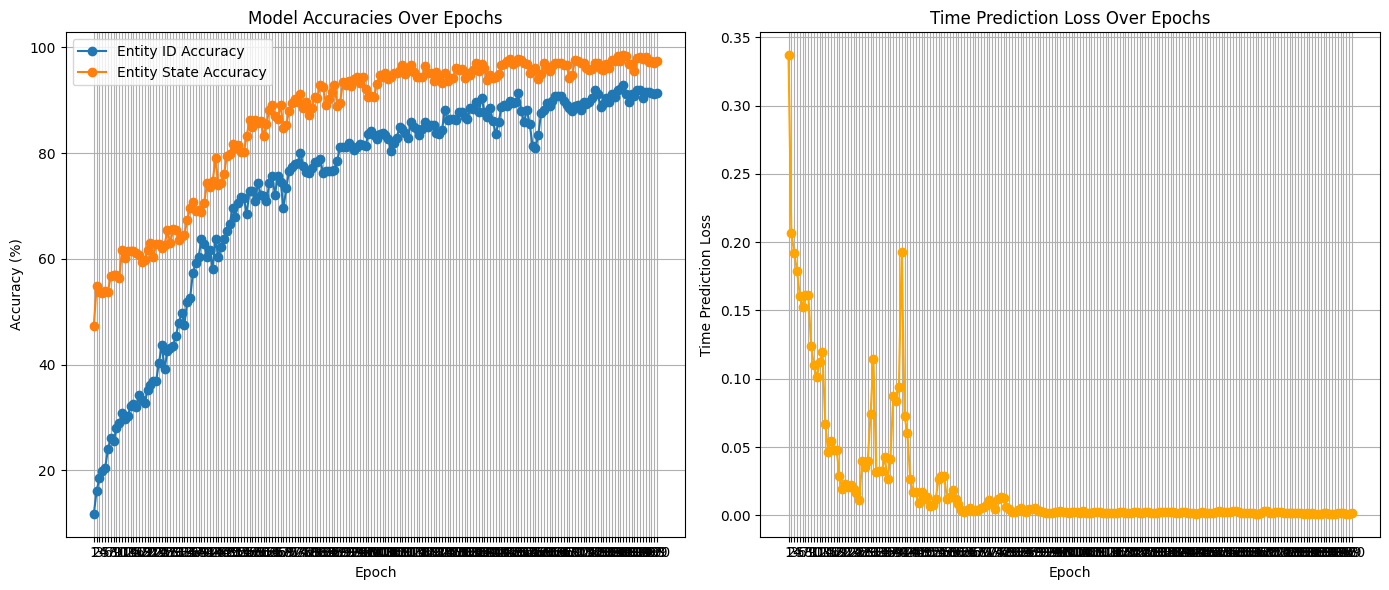

In [13]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, training_epoch + 1), entity_id_accuracies, marker='o', label='Entity ID Accuracy')
plt.plot(range(1, training_epoch + 1), entity_state_accuracies, marker='o', label='Entity State Accuracy')
plt.title('Model Accuracies Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.xticks(range(1, training_epoch + 1))  # Set x-ticks to match epoch numbers
plt.legend()
plt.grid()

# Plot time prediction loss
plt.subplot(1, 2, 2)
plt.plot(range(1, training_epoch + 1), time_losses, marker='o', color='orange')
plt.title('Time Prediction Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Time Prediction Loss')
plt.xticks(range(1, training_epoch + 1))  # Set x-ticks to match epoch numbers
plt.grid()

plt.tight_layout()
plt.show()

In [15]:
torch.save(model.state_dict(), 'transformer_multi_task_slim_200.pth')

In [16]:
loaded_model = TransformerMultiTask(input_dim=46, hidden_dim=512, additional_input_dim=5, num_heads=2, num_layers=1, entity_id_cls=45, entity_state_cls=4)
# Load the state dict
loaded_model.load_state_dict(torch.load('transformer_multi_task_slim_200.pth', weights_only=True))
loaded_model.eval()  # Set the model to evaluation mode

TransformerMultiTask(
  (embedding): Linear(in_features=46, out_features=512, bias=True)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (actionable_fc): Linear(in_features=517, out_features=2, bias=True)
  (entity_id_fc): Sequential(
    (0): Linear(in_features=517, out_features=256, bias=True)
    (1): SiLU()
    (2): Linear(in_features=